# Online model selection through bandit learning

### 0. Packages imports and functions definitions

#### NB options

In [76]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [77]:
FIGSIZE = (11, 7)

#### Packages imports

In [78]:
from collections import namedtuple
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from river import (
    optim,
    datasets,
    preprocessing,
    linear_model,
    metrics,
    compose
)
from river.expert import (
    EpsilonGreedyRegressor,
    UCBRegressor,
    RandomBanditRegressor,
    OracleBandit
)
from river.stream import iter_sklearn_dataset

### Functions for data generation

In [79]:
def make_xy_numpy(N=1000, p=1, intercept=0.0, seed=None, drift=False, noise_scale=1.0):
    N = int(N)
    
    if seed:
        np.random.seed(seed)

    beta = np.random.normal(size=p, scale=2)

    x_arr = np.random.normal(size=(N, p))
    noise = np.random.normal(size=N, scale=noise_scale)
    xb = intercept + np.sum(x_arr * beta, axis=1) 
    
    if drift:
        tier = N // 3
        xb[tier:(2 * tier)] *= -1
        xb[(2 * tier):] *= -1
        beta *= -1
        
    y_arr = xb + noise

    return x_arr, y_arr, beta


Dataset = namedtuple("dat", ["target", "data", "feature_names", "beta"])


def make_dataset(**kwargs):
    x_arr, y_arr, beta = make_xy_numpy(**kwargs)
    dataset = Dataset(y_arr, x_arr, ["x{}".format(i) for i in range(p)], beta)
    return dataset


def make_stream(dataset=None, take=None):
    if dataset is None:
        dataset = make_dataset()
    
    gen = iter_sklearn_dataset(dataset)
    
    if take:
        return itertools.islice(gen, take)
    else:
        return gen


### Functions for pipeline/models generation

In [80]:
l2_val = [1e-4, 1e-3, 1e-2, 1e-1, 1e-0, 2]
optimz = [optim.SGD]

def make_models(lr=0.35):
    grid = itertools.product(
        l2_val,
        [preprocessing.StandardScaler, preprocessing.MaxAbsScaler, preprocessing.MinMaxScaler, preprocessing.RobustScaler],
        optimz
    )
    
    return [generate_pipeline(l2=l2, lr=lr, scaler=scaler, optimizer=optimizer)
            for (l2, scaler, optimizer) in grid]

def make_pipeline(lr=0.2, l2=0, scaler=None, optimizer=None):
    if scaler is None:
        scaler =  preprocessing.MinMaxScaler()
    if optimizer is None:
        optimizer = optim.SGD

    pipeline = compose.Pipeline(
        scaler,
        linear_model.LinearRegression(optimizer=optimizer(), l2=l2)
    )
    
    return pipeline



# 1. Experimentation

We simulate a dataset with : 
- 10 000 observations
- 25 features that are iid $\mathcal{N}(0, 1)$.
- $\beta$ vector is distributed as $\mathcal{N}(0, 2)$
- The data generating process (DGP) is linear : $y=X^T\beta + \epsilon$ with $\epsilon$ ~ $\mathcal{N}(0, 0.5)$

In [81]:
def make_default_params():
    return dict(metric=metrics.MSE(), 
                reward_scaler=preprocessing.StandardScaler(),
                verbose=False,
                save_rewards=True,
                models=make_models(),
                save_percentage_pulled=True)

In [84]:
N = 4000
p = 25
dataset = make_dataset(p=p, N=N, intercept=2, drift=False, noise_scale=.5, seed=123)
take_N = 4000
use_oracle = True
use_provided_compute = False
metric = metrics.MSE()

In [85]:
bandits = {
    "epsilon" : EpsilonGreedyRegressor(epsilon=0.1, **make_default_params()),
    "ucb"     : UCBRegressor(delta=None, **make_default_params()),
    "random"  : RandomBanditRegressor(**make_default_params()),
}
bandit_oracle = OracleBandit(**make_default_params())

bandits_loss = {"oracle": [], "epsilon": [], "ucb" : [], "random" : []}
bandits_rewards = {"oracle": [], "epsilon": [], "ucb" : [], "random" : []}
bandits_regrets = {"oracle": [], "epsilon": [], "ucb" : [], "random" : []}

for bandit in bandits.values():
    if use_provided_compute:
        bandit.compute_reward = compute_reward
    else:
        pass    

if use_provided_compute:
    bandit_oracle.compute_reward = compute_reward

print_every = take_N // 4

for i, (x, y) in tqdm.tqdm(enumerate(make_stream(dataset, take=take_N))):
    if use_oracle:
        oracle_pred = bandit_oracle.predict_one(x, y)
        #oracle_reward = compute_reward(oracle_pred, y)
        #bandits_rewards["oracle"] += [oracle_reward]

    for bandit_label in bandits:
        y_pred = bandits[bandit_label].predict_one(x=x)
        #bandit_reward = compute_reward(y_pred, y)
        if use_oracle:
            pass#bandits_regrets[bandit_label] += [oracle_reward - bandit_reward]
        #bandits_rewards[bandit_label] += [bandit_reward]
        #bandits_regrets[bandit_label] += [((y_pred - y) ** 2) -((oracle_pred - y) ** 2)]
        bandits_loss[bandit_label] += [metric._eval(y_pred, y)]
        
        bandits[bandit_label].learn_one(x=x, y=y)
        if (i % print_every) == 0:
            print(bandit_label, ":", bandits[bandit_label].metric.get())
    
    if use_oracle:
        bandits_loss["oracle"] += [(oracle_pred - y) ** 2]
        bandit_oracle.learn_one(x=x, y=y)
    
    if i == take_N // 2:
        for bandit_label in bandits:
            pass#bandits[bandit_label].add_models(list(np.random.choice(a=make_models(), size=10)))

4it [00:00, 39.92it/s]

epsilon : 229.71799237049578
ucb : 229.71799237049578
random : 229.71799237049578


19it [00:00, 42.50it/s]

epsilon : 163.37421455727304
ucb : 165.5515506841922
random : 168.30757035416102
epsilon : 132.80810825707255
ucb 

28it [00:00, 41.96it/s]

: 158.4716180618535
random : 163.59340974657496


37it [00:00, 42.04it/s]

epsilon : 108.0012941962119
ucb : 148.33454945434582
random : 150.9586315617013


40it [00:00, 42.39it/s]


# 3. Results analysis

## 3.1. Percentages of times pulled (for a given bandit)

In [64]:
def prepared_percentage_df(percentage_pulled, threshold=0.5/100):
    times_pulled_df = pd.DataFrame(({i:pct for (i,pct) in enumerate(array)} for array in percentage_pulled))
    most_pulled = times_pulled_df.mean(axis=0)[lambda s: s >= threshold].index
    less_pulled = set(times_pulled_df.columns) - set(most_pulled)
    cleaned_pulled  = pd.concat([times_pulled_df.loc[:,list(most_pulled)],
                                 times_pulled_df[less_pulled].sum(axis=1).rename("other").to_frame()],
                                axis=1)
    return cleaned_pulled

In [65]:
cleaned_pulled  = prepared_percentage_df(bandits["ucb"].store_percentage_pulled,
                                        threshold=.5/100)

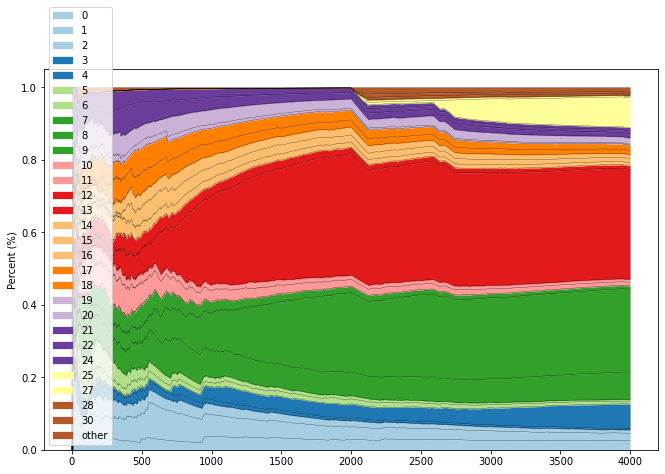

In [66]:
ax = cleaned_pulled.plot(kind="area", colormap="Paired", linewidth=.25, figsize=FIGSIZE)
ax.set_ylabel('Percent (%)')
[l.set_color("black") for l in ax.lines]
plt.show()

## 3.2. Comparing bandits loss (lower is better)

#### Rolling loss

The loss is defined as the squared difference between the target `y` and the prediction `y_pred` that is given by the method `predict_one`. Note that the `predict_one` method returns the prediction of the model with the highest average reward.

<AxesSubplot:>

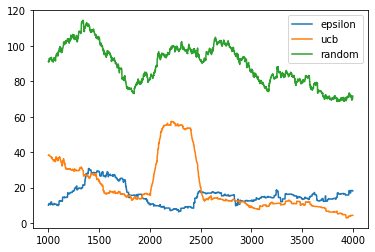

In [70]:
(pd.DataFrame({key:value[:] for key,value in bandits_loss.items() if len(value) > 0})
 .rolling(400)
 .mean()
 .iloc[1000:]
 .plot())

#### Cumulated sum of loss (lower is better)

<AxesSubplot:>

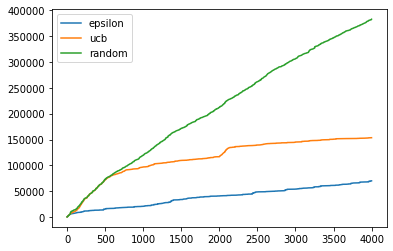

In [71]:
(pd.DataFrame({key:value for key, value in bandits_loss.items() if len(value) > 0})
 .cumsum()
 .plot())

## 3.3. Others (Regret analysis)